<h1>Transfer Learning with BERT</h1>

In [51]:
# References
# https://colab.research.google.com/drive/1IubZ3T7gqD09ZIVmJapiB5MXUnVGlzwH#scrollTo=7LbVjtktg3Ln
# https://medium.com/analytics-vidhya/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8
# https://medium.com/@brn.pistone/bert-fine-tuning-for-tensorflow-2-0-with-keras-api-9913fc1348f6

# https://www.aclweb.org/anthology/W18-4407.pdf
# https://www.aclweb.org/anthology/W18-4408.pdf

# Requirements
# pip install sentencepiece
# pip install tensorflow_hub
# pip install tensorflow
# pip install bert-for-tf2
# pip install transformers

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import bert
import os
import numpy as np
import random
import re
from datetime import datetime
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
import bert
from bert import bert_tokenization 

print('Libraries loaded')


Libraries loaded


<h2>Settings</h2>

In [2]:
CLASSES = ['CAG', 'NAG', 'OAG']
MAX_LENGTH = 128
TRAIN_MODEL = True
RETRAIN_BERT = False
TRAIN_SAMPLES = 0.8
LOAD_MODEL_AND_PREDICT = True
TEXT_TO_PREDICT = ['That is a well reasoned point',
                   'This is happening in BJP ruled state. Shame on the adminstration']
DATA_FILE = 'Data/agr_en_train.csv'
print('Settings set')

Settings set


<h2>Load BERT Model from Tensorflow HUB</h2>

In [3]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path,trainable=True)
print('Model Loaded')

vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)
print('Tokenizer Created')

print('Sample Tokenizer Operations')
sample_x = tokenizer.tokenize('this is a sample tokening operation. It spans multiple sentences')
sample_ids = tokenizer.convert_tokens_to_ids(sample_x)
print(sample_x)
print(sample_ids)

Model Loaded
Tokenizer Created
Sample Tokenizer Operations
['this', 'is', 'a', 'sample', 'token', '##ing', 'operation', '.', 'it', 'spans', 'multiple', 'sentences']
[2023, 2003, 1037, 7099, 19204, 2075, 3169, 1012, 2009, 14798, 3674, 11746]


<h2>Load Data and Explore</h2>
<p>Want to make sure the target labels are well balanced. Also need to find the average length of the posts as the BERT model requires inputs up to a certain length</p>

Wordcount distribution


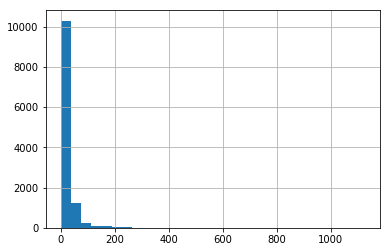

Label distribution


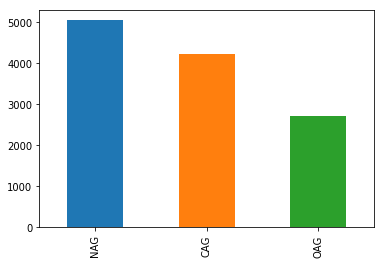

English distribution


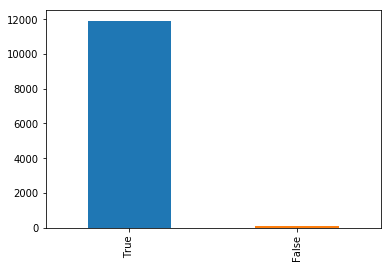

                                                   Text Indicator  Length  \
41                   modi ji all the pain  nö real gain       CAG       9   
314   yàar my ears are bleeding stop this  get the b...       CAG      13   
813            रजनथ सह फर कहग क हम ननद करत ह डब मर सरकर       CAG      12   
830    bot powered by prince fadii  just now done  i...       NAG      61   
1107   bot powered by ishaq zada  see my bot speed  ...       NAG      66   
1441       live  nse स pehlakadam season 2 grand finale       NAG       9   
1462  what you should know about turkeys president r...       NAG     297   
1621   bot powered by prince fadii  see my bot speed...       NAG      62   
1704  a question of order india turkey and the retur...       CAG     106   
1719  अर कछ त कर खल हजड क तरह तल बजत रहन स कछ नह हग ...       OAG      25   

      isEnglish  
41        False  
314       False  
813       False  
830       False  
1107      False  
1441      False  
1462      False  
1621    

In [47]:
def remove_URL(s):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", s)

def remove_punctuation(s):
    return re.sub(r'[^\w\s]', '', s)
    
def remove_Emoji(s):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', s)

def replace_chars(Data):
    Data['Text'] = Data['Text'].str.replace('\n',' ')
    Data['Text'] = Data['Text'].str.replace('  ',' ')
    Data['Text'] = Data['Text'].str.strip()
    Data['Text'] = Data['Text'].str.lower()
    Data['Text'] = Data['Text'].str.replace('pls','please')
    Data['Text'] = Data['Text'].str.replace('plz','please')
    Data['Text'] = Data['Text'].str.replace(' u ',' you ')
    Data['Text'] = Data['Text'].str.replace(' ur ',' your ')
    Data['Text'] = Data['Text'].str.replace(' vs ',' versus ')
    Data['Text'] = Data['Text'].str.replace(' tks ',' thanks ')
    Data['Text'] = Data['Text'].str.replace(' tkz ',' thanks ')
    Data['Text'] = Data['Text'].str.replace(' cud ',' could ')
    Data['Text'] = Data['Text'].str.replace(' b ',' be ')
    Data['Text'] = Data['Text'].str.replace(' r ',' are ')
    Data['Text'] = Data['Text'].str.replace(' gonna ',' going to ')
    Data['Text'] = Data['Text'].str.replace(' y ',' why ')
    Data['Text'] = Data['Text'].str.replace('bn ',' billion ')
    Data['Text'] = Data['Text'].str.replace('tn ',' trillion ')
    Data['Text'] = Data['Text'].str.replace('£',' pounds ')
    Data['Text'] = Data['Text'].str.replace('$',' dollars ')
    return Data

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def create_data_frame():
    data = pd.read_csv(DATA_FILE)
    data.columns = ['ID','Text','Indicator']
    data.drop(['ID'], axis='columns', inplace = True)
    
    data = replace_chars(data)
    data['Text'] = data['Text'].apply(remove_Emoji)
    data['Text'] = data['Text'].apply(remove_URL)
    data['Text'] = data['Text'].apply(remove_punctuation)
    data['Length'] = data['Text'].str.split(' ').apply(len)
    data['isEnglish'] = data['Text'].apply(isEnglish)
    return data

data = create_data_frame()
print('Wordcount distribution')
data['Length'].hist(bins=30)
plt.show()
print('Label distribution')
data['Indicator'].value_counts().plot(kind='bar')
plt.show()
print('English distribution')
data['isEnglish'].value_counts().plot(kind='bar')
plt.show()
print(data[data['isEnglish']==False][0:10])


<p>The target labels aren't balanced and the length of the text in the samples is quite skewed. Both properties could affect the training of a classifier, also feature-based transfer learning using BERT can cope with far fewer samples, so at this point some samples will be filtered out to improve the quality of the set.

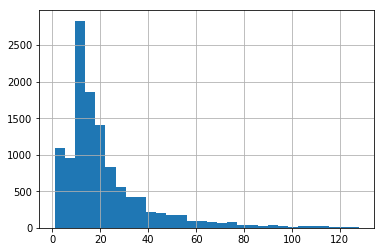

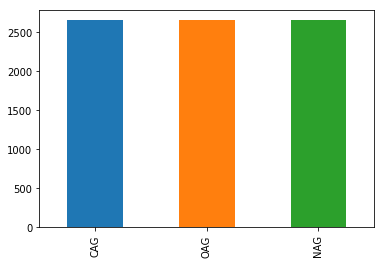

New dataset length 7944


In [48]:
def remove_too_long_samples(data):
    return data[data['Length']<=MAX_LENGTH]

def balance_samples_for_labels(data):
    oags = data[data['Indicator']=='OAG']
    length = len(oags.index)
    cags = data[data['Indicator']=='CAG'].sample(n=length,random_state=42)
    nags = data[data['Indicator']=='NAG'].sample(n=length,random_state=42)
    all_stuff = pd.concat([oags,cags,nags])
    
    #shuffle dataset
    return all_stuff.sample(n=len(all_stuff.index), random_state=42)
    
data = remove_too_long_samples(data)
data['Length'].hist(bins=30)
plt.show()
data = balance_samples_for_labels(data)
data['Indicator'].value_counts().plot(kind='bar')
plt.show()
print('New dataset length %s' % len(data.index))


<h2>Data Processing</h2>
<p>The Bert model loaded from TF Hub expects input data in a particular format. For every text sample, three arrays are created: most importantly the sample is tokenised and then converted to Ids using BERTs tokenizer dictionary. An input mask array and sentence location (not used for classification) array are also created.

In [49]:
def Bertify(Set):
    
    tokens = map(tokenizer.tokenize, Set)
    tokens = map(lambda tok: tok[:MAX_LENGTH-2], tokens)
    tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], tokens)
    
    token_ids = map(tokenizer.convert_tokens_to_ids, tokens)
    token_ids = map(lambda tids: tids + [0] * (MAX_LENGTH - len(tids)), token_ids)
    # token_ids = map(lambda tids: np.array(tids), token_ids)
    token_ids = list(token_ids)
    token_masks =[]
    sent_segs = []
    for token_list in token_ids:
        token_masks.append([1 if x > 0 else 0 for x in token_list])
        sent_segs.append([0 for x in token_list])    
    return  [tf.cast(token_ids,tf.int32), tf.cast(sent_segs,tf.int32), tf.cast(token_masks,tf.int32)]

def preprocess_data(data): 
    #One hot encoding
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(CLASSES)
    label_ints = label_encoder.transform(data.values[:,1])
    label_ints = label_ints.reshape(len(label_ints), 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    label_onehot = onehot_encoder.fit_transform(label_ints)
    
    #Split to training and test
    train_len = int(len(data.index) * TRAIN_SAMPLES)
    
    train_set = data.values[:train_len,0]
    train_features = Bertify(train_set)
    train_labels = np.array(label_onehot[:train_len,:])
    
    test_set = data.values[train_len:,0]
    test_features = Bertify(test_set)
    test_labels = np.array(label_onehot[train_len:,:])
    
    return train_features, train_labels, test_features, test_labels

if TRAIN_MODEL:
    train_tokens, train_labels, test_tokens, test_labels = preprocess_data(data)
    print('Training data loaded')
    print(train_tokens[0:10])
    print(train_labels[0:10])
else:
    print('Training data not loaded')

Training data loaded
[<tf.Tensor: shape=(6355, 128), dtype=int32, numpy=
array([[  101,  2821,  2061, ...,     0,     0,     0],
       [  101, 12264,   102, ...,     0,     0,     0],
       [  101,  6522,  2860, ...,     0,     0,     0],
       ...,
       [  101,  2079,  1996, ...,     0,     0,     0],
       [  101,  2023,  7221, ...,     0,     0,     0],
       [  101,  1037,  5160, ...,     0,     0,     0]])>, <tf.Tensor: shape=(6355, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(6355, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]


<h2>Model Definition</h2>

In [76]:
METRICS = [
      tf.keras.metrics.CategoricalCrossentropy(name='categoricalcrossentropy'),
      tf.keras.metrics.CategoricalAccuracy(name='categoricalaccuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def build_model_fullyconnected():
    """add pretrained bert model as a keras layer"""
    input_word_ids = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_ids')
    input_masks = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_masks')
    input_segments = Input((MAX_LENGTH,), dtype=tf.int32, name='input_sent_segms')
    
    if not RETRAIN_BERT:
        bert_layer.trainable = False
    
    _, sout = bert_layer([input_word_ids, input_masks, input_segments])
    # X = GlobalAveragePooling1D()(sout)
    X = Conv1D(128, 5, activation='relu')(sout)
    X = AveragePooling1D()(X)
    X = Conv1D(64, 5, activation='relu')(X)
    X = GlobalAveragePooling1D()(X)
    X = Dense(32, activation='relu')(X) 
    X = Dropout(0.35)(X)
    X = Dense(16, activation='relu')(X) 
    X = Dropout(0.35)(X)
    output_= Dense(3, activation=tf.nn.softmax, name='output')(X)

    #model = Model(input_,output_)
    model = Model([input_word_ids, input_masks, input_segments],output_)
    model.compile(optimizer = "adam",loss = "categorical_crossentropy",
                    metrics = METRICS)
    return model

model = build_model_fullyconnected()
print(model.summary())
print('done')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token_ids (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_token_masks (InputLayer)  [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_sent_segms (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_token_ids[0][0]            
                                                                 input_token_masks[0][0]    

<h2>Model Training</h2>

In [77]:
def fitModel(Model, training_set, training_label, testing_set, testing_label):
    checkpointName = os.path.join('Model', "bert_faq.ckpt")

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                     save_weights_only=True,
                                                     save_freq = 10000,
                                                     mode='auto',
                                                     verbose=1)
    # callback = StopTrainingClassComplete()

    history = Model.fit(
        training_set,
        training_label,
        epochs=100,
        validation_data=(testing_set, testing_label),
        verbose=1,
        callbacks=[cp_callback]
    )
    return history

if TRAIN_MODEL:
    history = fitModel(model, train_tokens, train_labels, test_tokens, test_labels)
else:
    print('Model training skipped')

Train on 6355 samples, validate on 1589 samples
Epoch 1/100
6355/6355 [==============================] - 105s 17ms/sample - loss: 1.1104 - categoricalcrossentropy: 1.1104 - categoricalaccuracy: 0.3382 - precision: 0.3054 - recall: 0.0098 - auc: 0.5053 - val_loss: 1.0984 - val_categoricalcrossentropy: 1.0984 - val_categoricalaccuracy: 0.3392 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5156
Epoch 2/100
3616/6355 [================>.............] - ETA: 34s - loss: 1.0980 - categoricalcrossentropy: 1.0980 - categoricalaccuracy: 0.3280 - precision: 0.5000 - recall: 0.0033 - auc: 0.4906
Epoch 00002: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 108s 17ms/sample - loss: 1.0988 - categoricalcrossentropy: 1.0988 - categoricalaccuracy: 0.3364 - precision: 0.4634 - recall: 0.0030 - auc: 0.4973 - val_loss: 1.0986 - val_categoricalcrossentropy: 1.0986 - val_categoricalaccuracy: 0.3379 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val

6355/6355 [==============================] - 100s 16ms/sample - loss: 0.6755 - categoricalcrossentropy: 0.6755 - categoricalaccuracy: 0.7018 - precision: 0.7534 - recall: 0.5862 - auc: 0.8743 - val_loss: 1.2852 - val_categoricalcrossentropy: 1.2852 - val_categoricalaccuracy: 0.4947 - val_precision: 0.5101 - val_recall: 0.4449 - val_auc: 0.6912
Epoch 18/100
2080/6355 [========>.....................] - ETA: 53s - loss: 0.6099 - categoricalcrossentropy: 0.6099 - categoricalaccuracy: 0.7341 - precision: 0.7788 - recall: 0.6346 - auc: 0.8978
Epoch 00018: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 107s 17ms/sample - loss: 0.6138 - categoricalcrossentropy: 0.6138 - categoricalaccuracy: 0.7304 - precision: 0.7676 - recall: 0.6480 - auc: 0.8954 - val_loss: 1.3037 - val_categoricalcrossentropy: 1.3037 - val_categoricalaccuracy: 0.4896 - val_precision: 0.4990 - val_recall: 0.4613 - val_auc: 0.6824
Epoch 19/100
5728/6355 [==========================>...] - ETA:

6355/6355 [==============================] - 100s 16ms/sample - loss: 0.1623 - categoricalcrossentropy: 0.1623 - categoricalaccuracy: 0.9533 - precision: 0.9539 - recall: 0.9530 - auc: 0.9913 - val_loss: 3.1739 - val_categoricalcrossentropy: 3.1739 - val_categoricalaccuracy: 0.5035 - val_precision: 0.5038 - val_recall: 0.5035 - val_auc: 0.6800
Epoch 34/100
 544/6355 [=>............................] - ETA: 1:13 - loss: 0.1298 - categoricalcrossentropy: 0.1298 - categoricalaccuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9953
Epoch 00034: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 107s 17ms/sample - loss: 0.1583 - categoricalcrossentropy: 0.1583 - categoricalaccuracy: 0.9539 - precision: 0.9543 - recall: 0.9534 - auc: 0.9922 - val_loss: 3.6143 - val_categoricalcrossentropy: 3.6143 - val_categoricalaccuracy: 0.5053 - val_precision: 0.5057 - val_recall: 0.5053 - val_auc: 0.6793
Epoch 35/100
4192/6355 [==================>...........] - ETA

5344/6355 [========================>.....] - ETA: 12s - loss: 0.0995 - categoricalcrossentropy: 0.0995 - categoricalaccuracy: 0.9740 - precision: 0.9743 - recall: 0.9736 - auc: 0.9959
Epoch 00049: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 107s 17ms/sample - loss: 0.0998 - categoricalcrossentropy: 0.0998 - categoricalaccuracy: 0.9740 - precision: 0.9743 - recall: 0.9737 - auc: 0.9958 - val_loss: 3.9910 - val_categoricalcrossentropy: 3.9910 - val_categoricalaccuracy: 0.5047 - val_precision: 0.5047 - val_recall: 0.5047 - val_auc: 0.6784
Epoch 50/100
6355/6355 [==============================] - 100s 16ms/sample - loss: 0.0766 - categoricalcrossentropy: 0.0766 - categoricalaccuracy: 0.9813 - precision: 0.9819 - recall: 0.9813 - auc: 0.9972 - val_loss: 5.3402 - val_categoricalcrossentropy: 5.3402 - val_categoricalaccuracy: 0.5060 - val_precision: 0.5060 - val_recall: 0.5060 - val_auc: 0.6742
Epoch 51/100
2656/6355 [===========>..................] - ETA:

3808/6355 [================>.............] - ETA: 32s - loss: 0.0658 - categoricalcrossentropy: 0.0658 - categoricalaccuracy: 0.9832 - precision: 0.9837 - recall: 0.9827 - auc: 0.9980
Epoch 00065: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 107s 17ms/sample - loss: 0.0659 - categoricalcrossentropy: 0.0659 - categoricalaccuracy: 0.9843 - precision: 0.9846 - recall: 0.9839 - auc: 0.9978 - val_loss: 5.5067 - val_categoricalcrossentropy: 5.5067 - val_categoricalaccuracy: 0.5028 - val_precision: 0.5028 - val_recall: 0.5028 - val_auc: 0.6581
Epoch 66/100
6355/6355 [==============================] - 100s 16ms/sample - loss: 0.0754 - categoricalcrossentropy: 0.0754 - categoricalaccuracy: 0.9770 - precision: 0.9773 - recall: 0.9770 - auc: 0.9976 - val_loss: 5.1411 - val_categoricalcrossentropy: 5.1411 - val_categoricalaccuracy: 0.4833 - val_precision: 0.4833 - val_recall: 0.4833 - val_auc: 0.6537
Epoch 67/100
1120/6355 [====>.........................] - ETA:

2272/6355 [=========>....................] - ETA: 51s - loss: 0.0635 - categoricalcrossentropy: 0.0635 - categoricalaccuracy: 0.9824 - precision: 0.9824 - recall: 0.9811 - auc: 0.9979
Epoch 00081: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 107s 17ms/sample - loss: 0.0648 - categoricalcrossentropy: 0.0648 - categoricalaccuracy: 0.9830 - precision: 0.9833 - recall: 0.9825 - auc: 0.9979 - val_loss: 5.1527 - val_categoricalcrossentropy: 5.1527 - val_categoricalaccuracy: 0.4877 - val_precision: 0.4874 - val_recall: 0.4871 - val_auc: 0.6565
Epoch 82/100
5920/6355 [==========================>...] - ETA: 5s - loss: 0.0564 - categoricalcrossentropy: 0.0564 - categoricalaccuracy: 0.9848 - precision: 0.9853 - recall: 0.9843 - auc: 0.9983
Epoch 00082: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 108s 17ms/sample - loss: 0.0578 - categoricalcrossentropy: 0.0578 - categoricalaccuracy: 0.9843 - precision: 0.9847 - recall: 0.983

 736/6355 [==>...........................] - ETA: 1:10 - loss: 0.0372 - categoricalcrossentropy: 0.0372 - categoricalaccuracy: 0.9891 - precision: 0.9891 - recall: 0.9878 - auc: 0.9995
Epoch 00097: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 107s 17ms/sample - loss: 0.0735 - categoricalcrossentropy: 0.0735 - categoricalaccuracy: 0.9789 - precision: 0.9801 - recall: 0.9780 - auc: 0.9974 - val_loss: 6.7227 - val_categoricalcrossentropy: 6.7227 - val_categoricalaccuracy: 0.5041 - val_precision: 0.5051 - val_recall: 0.5016 - val_auc: 0.6668
Epoch 98/100
4384/6355 [===================>..........] - ETA: 24s - loss: 0.0561 - categoricalcrossentropy: 0.0561 - categoricalaccuracy: 0.9836 - precision: 0.9842 - recall: 0.9822 - auc: 0.9983
Epoch 00098: saving model to Model\bert_faq.ckpt
6355/6355 [==============================] - 108s 17ms/sample - loss: 0.0556 - categoricalcrossentropy: 0.0556 - categoricalaccuracy: 0.9825 - precision: 0.9834 - recall: 0.9

<h2>Training and Testing Metrics</h2>

<h3>Categorical Crossentropy</h3>
<p></p>

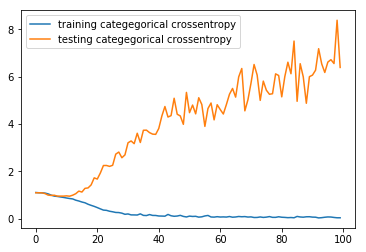

In [78]:
if TRAIN_MODEL:
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['categoricalcrossentropy'], label = 'training categegorical crossentropy')
    ax.plot(history.history['val_categoricalcrossentropy'], label = 'testing categegorical crossentropy')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h3>Categorical Accuracy</h3>
<p></p>

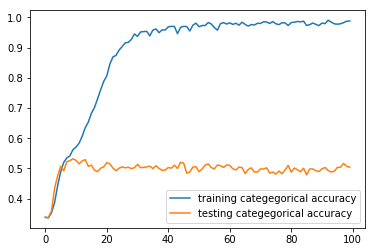

In [79]:
if TRAIN_MODEL:   
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['categoricalaccuracy'], label = 'training categegorical accuracy')
    ax.plot(history.history['val_categoricalaccuracy'], label = 'testing categegorical accuracy')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h3>Precision</h3>
<p></p>

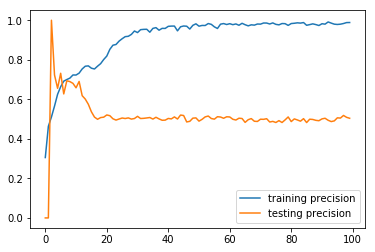

In [80]:
if TRAIN_MODEL:
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['precision'], label = 'training precision')
    ax.plot(history.history['val_precision'], label = 'testing precision')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h3>Recall</h3>
<p></p>

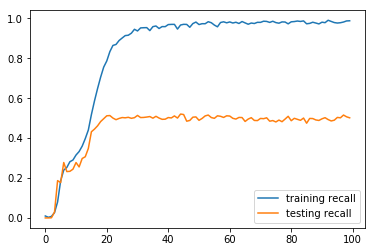

In [81]:
if TRAIN_MODEL:
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['recall'], label = 'training recall')
    ax.plot(history.history['val_recall'], label = 'testing recall')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h2>Running Predictions Using The Saved Model</h2>

In [72]:
def Load_Checkpoint(Model):
    
    latest_checkpoint = tf.train.latest_checkpoint('Model')
    #loaded_model = build_model_fullyconnected()
    
    print('Model build with random weights')
    #Model.evaluate(test_tokens, test_labels, verbose=2)
       
    Model.load_weights(latest_checkpoint)
    print('Weights loaded')
    #Model.evaluate(test_tokens, test_labels, verbose=2)
    
    return Model
    
def Model_Predictions(Model, Text_Array):
    inputs = Bertify(Text_Array)
    predicted_labels = Model.predict(inputs)
    label_indices = np.argmax(predicted_labels, axis=1)
    labels = [CLASSES[x] for x in label_indices]
    return labels

if LOAD_MODEL_AND_PREDICT:
    model = Load_Checkpoint(model)
    predictions = Model_Predictions(model, TEXT_TO_PREDICT)
    for text, prediction in zip(TEXT_TO_PREDICT, predictions):
        print(text)
        print(prediction)


Model build with random weights
Weights loaded
That is a well reasoned point
NAG
This is happening in BJP ruled state. Shame on the adminstration
OAG
